In [1]:
!pip install alibi[tf] -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 78.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 80.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.7/14.7 MB 90.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 522.1/522.1 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.6/6.6 MB 91.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.2/920.2 kB 36.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.5/98.5 MB 17.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.8.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
dopamine-rl 4.1.2 requires gymnasium>=1.0.0, but you have gymnasium 0.29.0 which is incompatible.
g

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Conv1D, MaxPooling1D, GRU, Dense, 
                                   Dropout, Bidirectional, Attention, GlobalMaxPooling1D,
                                   LSTM, Flatten, GlobalAveragePooling1D, Lambda)
from tensorflow.keras.optimizers import Adam
from transformers import AutoTokenizer, TFAutoModel
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Dropout, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFAutoModel, AutoTokenizer
import re
import time
from collections import Counter
import warnings
from transformers import logging
warnings.filterwarnings('ignore')

# Interpretability libraries
import lime
import lime.lime_tabular
from alibi.explainers import IntegratedGradients
import random

import tensorflow as tf
from transformers import logging

tf.get_logger().setLevel('ERROR')
logging.set_verbosity_error()

import os
# Suppress TensorFlow and XLA backend logs
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'   # 0=all logs, 1=info, 2=warning, 3=error only
# Suppress HuggingFace warnings
logging.set_verbosity_error()

# Optional: TensorFlow logger to show only errors
tf.get_logger().setLevel('ERROR')

import tensorflow as tf


# Suppress HuggingFace warnings
logging.set_verbosity_error()

# Optional: ensure TensorFlow only shows errors
tf.get_logger().setLevel('ERROR')

import tensorflow as tf
from transformers import logging

# Suppress HuggingFace warnings
logging.set_verbosity_error()

2025-09-24 09:03:37.980660: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758704618.327184      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758704618.427489      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Load and prepare data
df = pd.read_csv('malicious_phish.csv')
df = df.dropna()
df = df[df['url'].str.len() > 5]

label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['type'])
class_names = label_encoder.classes_

print("Class distribution:")
print(df['type'].value_counts())

Class distribution:
type
benign        428103
defacement     96457
phishing       94103
malware        32520
Name: count, dtype: int64


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [5]:
class URLPreprocessor:
    def __init__(self, max_length=200):
        self.max_length = max_length
        self.char_vocab = None
        self.char_to_idx = None
        self.idx_to_char = None
        
    def normalize_url(self, url):
        """Normalize URL by converting to lowercase and cleaning"""
        url = url.lower().strip()
        url = re.sub(r'^https?://', '', url)
        url = re.sub(r'^www\.', '', url)
        return url
    
    def create_char_vocab(self, urls):
        """Create character vocabulary from URLs"""
        all_chars = set()
        for url in urls:
            all_chars.update(url)
        
        self.char_vocab = ['<PAD>', '<UNK>'] + sorted(list(all_chars))
        self.char_to_idx = {char: idx for idx, char in enumerate(self.char_vocab)}
        self.idx_to_char = {idx: char for char, idx in self.char_to_idx.items()}
        return len(self.char_vocab)
    
    def url_to_char_sequence(self, url):
        """Convert URL to character sequence"""
        if self.char_to_idx is None:
            raise ValueError("Character vocabulary not created. Call create_char_vocab first.")
        
        url = self.normalize_url(url)
        sequence = [self.char_to_idx.get(char, self.char_to_idx['<UNK>']) for char in url]
        
        if len(sequence) < self.max_length:
            sequence += [self.char_to_idx['<PAD>']] * (self.max_length - len(sequence))
        else:
            sequence = sequence[:self.max_length]
            
        return sequence

In [6]:
class SimpleCNNModel:
    """Simple CNN without hybrid architecture"""
    def __init__(self, vocab_size, embedding_dim=128, max_length=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.model = None
        
    def build_model(self):
        inputs = Input(shape=(self.max_length,), dtype='int32')
        x = Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length)(inputs)
        x = Conv1D(64, 3, activation='relu')(x)
        x = MaxPooling1D(2)(x)
        x = Conv1D(128, 3, activation='relu')(x)
        x = GlobalMaxPooling1D()(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(4, activation='softmax')(x)
        
        self.model = Model(inputs, outputs)
        self.model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return self.model

class SimpleRNNModel:
    """Simple RNN without hybrid architecture"""
    def __init__(self, vocab_size, embedding_dim=128, max_length=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.model = None
        
    def build_model(self):
        inputs = Input(shape=(self.max_length,), dtype='int32')
        x = Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length)(inputs)
        x = Bidirectional(LSTM(128, return_sequences=False))(x)
        x = Dense(64, activation='relu')(x)
        x = Dropout(0.5)(x)
        outputs = Dense(4, activation='softmax')(x)
        
        self.model = Model(inputs, outputs)
        self.model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        return self.model


In [7]:
class CharCNNGRUModel:
    def __init__(self, vocab_size, embedding_dim=128, max_length=200):
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.max_length = max_length
        self.model = None
        self.attention_model = None  # For attention visualization
        
    def build_model(self):
        """Build CharCNN+GRU hybrid model with attention"""
        inputs = Input(shape=(self.max_length,), dtype='int32')
        
        # Character embedding
        x = Embedding(self.vocab_size, self.embedding_dim, input_length=self.max_length)(inputs)
        
        # CNN layers
        conv1 = Conv1D(64, 3, activation='relu', padding='same')(x)
        pool1 = MaxPooling1D(2)(conv1)
        conv2 = Conv1D(128, 3, activation='relu', padding='same')(pool1)
        pool2 = MaxPooling1D(2)(conv2)
        conv3 = Conv1D(256, 3, activation='relu', padding='same')(pool2)
        
        # Bidirectional GRU
        gru = Bidirectional(GRU(128, return_sequences=True))(conv3)
        
        # Attention mechanism
        attention = Attention()([gru, gru])
        attention_pool = GlobalMaxPooling1D()(attention)
        
        # Classification layers
        dense1 = Dense(128, activation='relu')(attention_pool)
        dropout1 = Dropout(0.5)(dense1)
        dense2 = Dense(64, activation='relu')(dropout1)
        outputs = Dense(4, activation='softmax')(dense2)
        
        self.model = Model(inputs, outputs)
        self.model.compile(optimizer=Adam(0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
        
        # Create separate model for attention visualization
        self.attention_model = Model(inputs=inputs, outputs=attention)
        
        return self.model
    
    def get_attention_weights(self, url_sequence):
        """Get attention weights for a URL sequence"""
        if self.attention_model is None:
            raise ValueError("Model not built. Call build_model first.")
        return self.attention_model.predict(np.array([url_sequence]))



from tensorflow.keras import mixed_precision

# Enable mixed precision globally
mixed_precision.set_global_policy('mixed_float16')

class BERTModel:
    def __init__(self, model_name='distilbert-base-uncased', num_classes=4):
        self.model_name = model_name
        self.tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.num_classes = num_classes
        self.model = None
        self.max_length = min(self.tokenizer.model_max_length, 128)  # cap to 128
        self.hidden_size = 768  # for distilbert-base-uncased

    def build_model(self):
        # Inputs
        input_ids = Input(shape=(self.max_length,), dtype=tf.int32, name='input_ids')
        attention_mask = Input(shape=(self.max_length,), dtype=tf.int32, name='attention_mask')

        # Load pretrained BERT
        bert_model = TFAutoModel.from_pretrained(self.model_name)

        # Lambda wrapper with output_shape
        def bert_call(inputs):
            ids, mask = inputs
            return bert_model(input_ids=ids, attention_mask=mask).last_hidden_state[:, 0, :]

        cls_token = Lambda(bert_call, output_shape=(self.hidden_size,))([input_ids, attention_mask])

        # Classification head
        x = Dropout(0.3)(cls_token)
        x = Dense(128, activation='relu')(x)
        # Ensure output is float32 for softmax even with mixed precision
        outputs = Dense(self.num_classes, activation='softmax', dtype='float32')(x)

        # Build and compile model
        self.model = Model(inputs=[input_ids, attention_mask], outputs=outputs)
        self.model.compile(
            optimizer=Adam(2e-5),
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )
        return self.model

In [8]:
class ModelInterpretability:
    def __init__(self, models, preprocessor, class_names):
        self.models = models
        self.preprocessor = preprocessor
        self.class_names = class_names
        
    def analyze_attention_weights(self, model_name, url, top_k=10):
        """Analyze attention weights for CharCNN+GRU model"""
        if model_name not in self.models or 'charcnn_gru' not in model_name.lower():
            print("Attention analysis only available for CharCNN+GRU model")
            return
        
        model = self.models[model_name]
        url_seq = self.preprocessor.url_to_char_sequence(url)
        attention_weights = model.get_attention_weights(url_seq)
        
        # Process attention weights
        attention_weights = attention_weights[0]  # Remove batch dimension
        attention_weights = np.mean(attention_weights, axis=1)  # Average across attention heads
        
        # Get top K important characters
        url_chars = [model.preprocessor.idx_to_char.get(idx, '?') for idx in url_seq if idx != 0]
        important_indices = np.argsort(attention_weights)[-top_k:][::-1]
        
        print(f"Top {top_k} important characters in URL:")
        for i, idx in enumerate(important_indices):
            if idx < len(url_chars):
                char = url_chars[idx]
                weight = attention_weights[idx]
                print(f"{i+1}. Character '{char}' at position {idx}: attention weight = {weight:.4f}")
        
        # Visualize attention weights
        plt.figure(figsize=(12, 2))
        plt.bar(range(len(attention_weights[:len(url_chars)])), attention_weights[:len(url_chars)])
        plt.title('Attention Weights Across URL Characters')
        plt.xlabel('Character Position')
        plt.ylabel('Attention Weight')
        plt.show()
        
        return attention_weights
    
    def integrated_gradients_analysis(self, model_name, url, target_class=None):
        """Implement Integrated Gradients for attribution analysis"""
        # Simplified integrated gradients implementation
        if model_name not in self.models:
            print(f"Model {model_name} not found")
            return
        
        model = self.models[model_name]
        if 'bert' in model_name.lower():
            # BERT model handling
            inputs = self.preprocessor.tokenizer([url], padding=True, truncation=True, 
                                               max_length=128, return_tensors='tf')
            baseline = self.preprocessor.tokenizer([''], padding=True, truncation=True,
                                                 max_length=128, return_tensors='tf')
        else:
            # Character-based model handling
            url_seq = np.array([self.preprocessor.url_to_char_sequence(url)])
            baseline = np.zeros_like(url_seq)
        
        # Simplified IG calculation
        predictions = model.model.predict(url_seq if 'bert' not in model_name.lower() else [inputs['input_ids'], inputs['attention_mask']])
        if target_class is None:
            target_class = np.argmax(predictions[0])
        
        print(f"Integrated Gradients Analysis for class: {self.class_names[target_class]}")
        print(f"Prediction confidence: {predictions[0][target_class]:.4f}")
        
        # This is a simplified version - full IG would require more complex implementation
        return predictions[0]
    
    def lime_explanation(self, model_name, url, num_features=10):
        """Generate LIME explanations for model predictions"""
        # Simplified LIME implementation for URL classification
        print(f"LIME Explanation for URL: {url}")
        
        # Create a simple surrogate model for explanation
        def predict_fn(urls):
            if model_name in self.models and 'bert' in model_name.lower():
                # BERT model prediction
                inputs = self.preprocessor.tokenizer(urls, padding=True, truncation=True, 
                                                   max_length=128, return_tensors='tf')
                return self.models[model_name].model.predict([inputs['input_ids'], inputs['attention_mask']])
            else:
                # Character-based model prediction
                sequences = [self.preprocessor.url_to_char_sequence(u) for u in urls]
                return self.models[model_name].model.predict(np.array(sequences))
        
        # For demonstration, we'll create a simple feature-based explanation
        features = self.extract_url_features([url])
        feature_names = ['length', 'num_dots', 'num_slashes', 'num_hyphens', 'has_@', 
                        'num_?', 'num_=', 'has_http', 'has_https', 'has_php', 
                        'has_html', 'has_exe', 'digit_count', 'special_char_count']
        
        print("Feature-based explanation (simplified LIME):")
        for i, (feature, value) in enumerate(zip(feature_names, features[0])):
            if i < num_features:
                print(f"{feature}: {value}")
        
        return features[0]
    
    def adversarial_example_analysis(self, model_name, original_url, target_class):
        """Generate adversarial examples by minimally modifying URLs"""
        print(f"Generating adversarial example for: {original_url}")
        print(f"Target class: {self.class_names[target_class]}")
        
        original_pred = self.models[model_name].model.predict(
            np.array([self.preprocessor.url_to_char_sequence(original_url)])
        )[0]
        
        print(f"Original prediction: {np.argmax(original_pred)} ({self.class_names[np.argmax(original_pred)]})")
        print(f"Original confidence: {np.max(original_pred):.4f}")
        
        # Simple adversarial modifications
        modifications = [
            original_url + '/test',  # Add path
            original_url.replace('.com', '.net'),  # Change TLD
            original_url + '?param=test',  # Add parameter
            'http://' + original_url,  # Add protocol
        ]
        
        print("\nAdversarial modifications tested:")
        for i, mod_url in enumerate(modifications):
            mod_pred = self.models[model_name].model.predict(
                np.array([self.preprocessor.url_to_char_sequence(mod_url)])
            )[0]
            print(f"{i+1}. {mod_url[:50]}... -> {np.argmax(mod_pred)} ({self.class_names[np.argmax(mod_pred)]})")
        
        return modifications
    
    def extract_url_features(self, urls):
        """Extract features for LIME explanations"""
        features = []
        for url in urls:
            url = url.lower()
            features.append([
                len(url),
                url.count('.'),
                url.count('/'),
                url.count('-'),
                int('@' in url),
                url.count('?'),
                url.count('='),
                int('http' in url),
                int('https' in url),
                int('php' in url),
                int('html' in url),
                int('exe' in url),
                sum(c.isdigit() for c in url),
                sum(not c.isalnum() for c in url)
            ])
        return np.array(features)

In [9]:
class ModelEvaluator:
    def __init__(self, model_name: str):
        self.model_name = model_name
        self.history = None

    def evaluate_model(self, model, X_test, y_test):
        start_time = time.time()

        # --- Step 1: Get probabilities or scores ---
        if hasattr(model, "predict_proba"):
            y_pred_proba = model.predict_proba(X_test)
        elif hasattr(model, "decision_function"):
            y_pred_proba = model.decision_function(X_test)
        else:
            # For Keras models and others without predict_proba
            y_pred_proba = model.predict(X_test)
        
        inference_time = time.time() - start_time

        # --- Step 2: Convert proba/scores to predictions ---
        # Handle different shapes of y_pred_proba
        if y_pred_proba.ndim == 1:
            # Binary classification scores (n_samples,)
            y_pred = (y_pred_proba > 0.5).astype(int)
        elif y_pred_proba.shape[1] == 1:
            # Binary classification probabilities (n_samples, 1)
            y_pred = (y_pred_proba.ravel() > 0.5).astype(int)
        elif y_pred_proba.shape[1] == 2:
            # Binary classification probabilities (n_samples, 2)
            y_pred = np.argmax(y_pred_proba, axis=1)
        else:
            # Multiclass classification (n_samples, n_classes)
            y_pred = np.argmax(y_pred_proba, axis=1)

        # --- Step 3: Metrics ---
        accuracy = np.mean(y_pred == y_test)
        report = classification_report(y_test, y_pred, output_dict=True)

        # --- Step 4: ROC-AUC ---
        try:
            if y_pred_proba.ndim == 1:
                # binary scores
                roc_auc = roc_auc_score(y_test, y_pred_proba)
            elif y_pred_proba.shape[1] == 1:
                # single-column probs
                roc_auc = roc_auc_score(y_test, y_pred_proba.ravel())
            elif y_pred_proba.shape[1] == 2:
                # binary probs → use positive class column
                roc_auc = roc_auc_score(y_test, y_pred_proba[:, 1])
            else:
                # multiclass
                roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class="ovr")
        except Exception as e:
            print(f"ROC-AUC calculation failed: {e}")
            roc_auc = np.nan

        # --- Step 5: Results dict ---
        n_samples = X_test[0].shape[0] if isinstance(X_test, tuple) else len(X_test)

        results = {
            "accuracy": accuracy,
            "precision": report["weighted avg"]["precision"],
            "recall": report["weighted avg"]["recall"],
            "f1_score": report["weighted avg"]["f1-score"],
            "roc_auc": roc_auc,
            "inference_time": inference_time / n_samples,
        }

        return results, y_pred, y_pred_proba

In [10]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(
    df['url'], df['label'], test_size=0.2, random_state=42, stratify=df['label']
)

# Preprocessing
preprocessor = URLPreprocessor(max_length=150)
vocab_size = preprocessor.create_char_vocab(X_train)

In [11]:
X_train_char = np.array([preprocessor.url_to_char_sequence(url) for url in X_train])
X_test_char = np.array([preprocessor.url_to_char_sequence(url) for url in X_test])

# Traditional ML models with feature engineering
def extract_ml_features(urls):
    features = []
    for url in urls:
        url = url.lower()
        features.append([
            len(url), url.count('.'), url.count('/'), url.count('-'),
            int('@' in url), url.count('?'), url.count('='),
            int('http' in url), int('https' in url),
            int('php' in url), int('html' in url), int('exe' in url),
            sum(c.isdigit() for c in url), sum(not c.isalnum() for c in url)
        ])
    return np.array(features)

X_train_ml = extract_ml_features(X_train)
X_test_ml = extract_ml_features(X_test)

In [12]:
# Train all models
models = {}
evaluators = {}

# 1. Traditional ML Models
print("Training traditional ML models...")
models['svm'] = SVC(probability=True, random_state=42,max_iter=100)
models['random_forest'] = RandomForestClassifier(n_estimators=100, random_state=42)
models['gradient_boosting'] = GradientBoostingClassifier(n_estimators=100,validation_fraction=0.1,
    n_iter_no_change=10, random_state=42)

for name, model in list(models.items()):
    if name in ['svm', 'random_forest', 'gradient_boosting']:
        print(f"Training {name} Model...")
        model.fit(X_train_ml, y_train)
        evaluators[name] = ModelEvaluator(name)

Training traditional ML models...
Training svm Model...
Training random_forest Model...
Training gradient_boosting Model...


In [13]:
# 2. Simple CNN and RNN
print("Training simple CNN...")
models['simple_cnn'] = SimpleCNNModel(vocab_size, max_length=X_train_char.shape[1])
models['simple_cnn'].build_model()
models['simple_cnn'].model.fit(X_train_char, y_train, validation_split=0.2, epochs=5, batch_size=64, verbose=1)

print("Training simple RNN...")
models['simple_rnn'] = SimpleRNNModel(vocab_size, max_length=X_train_char.shape[1])
models['simple_rnn'].build_model()
models['simple_rnn'].model.fit(X_train_char, y_train, validation_split=0.2, epochs=5, batch_size=64, verbose=1)


Training simple CNN...


I0000 00:00:1758705158.302322      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758705158.303099      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/5


I0000 00:00:1758705164.306357      81 service.cc:148] XLA service 0x7a1814007b00 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758705164.307699      81 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758705164.307721      81 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758705164.797388      81 cuda_dnn.cc:529] Loaded cuDNN version 90300


  46/6512 ━━━━━━━━━━━━━━━━━━━━ 22s 3ms/step - accuracy: 0.3532 - loss: 1.3693

I0000 00:00:1758705169.819983      81 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


6512/6512 ━━━━━━━━━━━━━━━━━━━━ 36s 4ms/step - accuracy: 0.3400 - loss: 1.3685 - val_accuracy: 0.3181 - val_loss: 1.3673
Epoch 2/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3403 - loss: 1.3685 - val_accuracy: 0.3181 - val_loss: 1.3673
Epoch 3/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3404 - loss: 1.3685 - val_accuracy: 0.3181 - val_loss: 1.3673
Epoch 4/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 23s 4ms/step - accuracy: 0.3400 - loss: 1.3685 - val_accuracy: 0.3181 - val_loss: 1.3673
Epoch 5/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 24s 4ms/step - accuracy: 0.3393 - loss: 1.3686 - val_accuracy: 0.3181 - val_loss: 1.3673
Training simple RNN...
Epoch 1/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 122s 18ms/step - accuracy: 0.8046 - loss: 0.5568 - val_accuracy: 0.8942 - val_loss: 0.2762
Epoch 2/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 113s 17ms/step - accuracy: 0.8975 - loss: 0.2716 - val_accuracy: 0.9166 - val_loss: 0.2178
Epoch 3/5
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 113s 17ms/step - accuracy: 0.919

In [14]:
# 3. CharCNN+GRU Hybrid
print("Training CharCNN+GRU hybrid model...")
models['charcnn_gru'] = CharCNNGRUModel(vocab_size, max_length=X_train_char.shape[1])
models['charcnn_gru'].build_model()
models['charcnn_gru'].preprocessor = preprocessor  # Store preprocessor for interpretability
history = models['charcnn_gru'].model.fit(X_train_char, y_train, validation_split=0.2, epochs=10, batch_size=64, verbose=1)
evaluators['charcnn_gru'] = ModelEvaluator('CharCNN+GRU')
evaluators['charcnn_gru'].history = history

Training CharCNN+GRU hybrid model...
Epoch 1/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 102s 15ms/step - accuracy: 0.8375 - loss: 0.4470 - val_accuracy: 0.9179 - val_loss: 0.2170
Epoch 2/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 95s 15ms/step - accuracy: 0.9207 - loss: 0.2086 - val_accuracy: 0.9320 - val_loss: 0.1784
Epoch 3/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - accuracy: 0.9327 - loss: 0.1758 - val_accuracy: 0.9357 - val_loss: 0.1671
Epoch 4/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - accuracy: 0.9390 - loss: 0.1574 - val_accuracy: 0.9369 - val_loss: 0.1644
Epoch 5/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - accuracy: 0.9441 - loss: 0.1458 - val_accuracy: 0.9385 - val_loss: 0.1620
Epoch 6/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 91s 14ms/step - accuracy: 0.9471 - loss: 0.1376 - val_accuracy: 0.9382 - val_loss: 0.1574
Epoch 7/10
6512/6512 ━━━━━━━━━━━━━━━━━━━━ 93s 14ms/step - accuracy: 0.9496 - loss: 0.1315 - val_accuracy: 0.9399 - val_loss: 0.1547
Epoch 8/10
6512/6512 ━━━━━━━━━━━━━━━━━

In [15]:
# 4. BERT Model
print("Training BERT model...")
models['bert'] = BERTModel()
models['bert'].max_length = 128  
models['bert'].build_model()
models['bert'].preprocessor = preprocessor

# Tokenize for BERT
X_train_bert = models['bert'].tokenizer(X_train.tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')
X_test_bert = models['bert'].tokenizer(X_test.tolist(), padding=True, truncation=True, max_length=128, return_tensors='tf')

history_bert = models['bert'].model.fit(
    [X_train_bert['input_ids'], X_train_bert['attention_mask']], y_train,
    validation_split=0.2, epochs=3, batch_size=1028, verbose=1
)
evaluators['bert'] = ModelEvaluator('BERT')
evaluators['bert'].history = history_bert

Training BERT model...


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch 1/3


W0000 00:00:1758706872.639202      78 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


405/406 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.5072 - loss: 1.1660

W0000 00:00:1758708158.300359      81 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


406/406 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.5075 - loss: 1.1656

W0000 00:00:1758708172.079133      81 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
W0000 00:00:1758708487.800012      81 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


406/406 ━━━━━━━━━━━━━━━━━━━━ 1633s 4s/step - accuracy: 0.5078 - loss: 1.1652 - val_accuracy: 0.6803 - val_loss: 0.7624
Epoch 2/3
406/406 ━━━━━━━━━━━━━━━━━━━━ 1579s 4s/step - accuracy: 0.7082 - loss: 0.7424 - val_accuracy: 0.7895 - val_loss: 0.5556
Epoch 3/3
406/406 ━━━━━━━━━━━━━━━━━━━━ 1579s 4s/step - accuracy: 0.7946 - loss: 0.5634 - val_accuracy: 0.8408 - val_loss: 0.4548


In [16]:
import numpy as np
import time
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score
from tensorflow.keras.utils import to_categorical

all_results = {}

# Determine if multiclass or binary
n_classes = len(np.unique(y_test))
is_multiclass = n_classes > 2

# For multiclass, one-hot encode y_test
if is_multiclass:
    y_test_onehot = to_categorical(y_test, num_classes=n_classes)
else:
    y_test_onehot = y_test

for name, model in models.items():
    print(f"\nEvaluating {name}...")
    start_time = time.time()
    
    # ----------------------------
    # 1. Get predicted probabilities
    # ----------------------------
    if name in ['svm', 'random_forest', 'gradient_boosting']:
        y_pred_proba = model.predict_proba(X_test_ml)
    elif name == 'bert':
        y_pred_proba = model.model.predict(
            [X_test_bert['input_ids'], X_test_bert['attention_mask']],
            verbose=0
        )
    else:  # CNN, RNN, CharCNN+GRU
        y_pred_proba = model.model.predict(X_test_char, verbose=0)
    
    # ----------------------------
    # 2. Get predicted class labels
    # ----------------------------
    if y_pred_proba.shape[1] > 1:  # multiclass
        y_pred = np.argmax(y_pred_proba, axis=1)
    else:  # binary
        y_pred = (y_pred_proba > 0.5).astype(int).ravel()
    
    # ----------------------------
    # 3. Compute metrics
    # ----------------------------
    accuracy = np.mean(y_pred == y_test)
    report = classification_report(y_test, y_pred, output_dict=True)
    
    # ROC-AUC calculation
    try:
        if is_multiclass:
            # Ensure shapes match
            if y_pred_proba.shape != y_test_onehot.shape:
                y_test_input = y_test_onehot
            else:
                y_test_input = y_test_onehot
            roc_auc = roc_auc_score(y_test_input, y_pred_proba, multi_class="ovr")
        else:
            roc_auc = roc_auc_score(y_test, y_pred_proba.ravel())
    except Exception as e:
        print(f"ROC-AUC calculation failed for {name}: {e}")
        roc_auc = np.nan
    
    inference_time = time.time() - start_time
    
    # ----------------------------
    # 4. Store results
    # ----------------------------
    results = {
        "accuracy": accuracy,
        "precision": report["weighted avg"]["precision"],
        "recall": report["weighted avg"]["recall"],
        "f1_score": report["weighted avg"]["f1-score"],
        "roc_auc": roc_auc,
        "inference_time": inference_time / len(y_test),
    }
    
    all_results[name] = results
    
    # ----------------------------
    # 5. Print results
    # ----------------------------
    print(f"{name.upper()} Results:")
    for metric, value in results.items():
        print(f"  {metric}: {value:.4f}")

# ----------------------------
# 6. Comparative analysis
# ----------------------------
results_df = pd.DataFrame(all_results).T
print("\nComparative Analysis:")
print(results_df)



Evaluating svm...
SVM Results:
  accuracy: 0.6574
  precision: 0.4322
  recall: 0.6574
  f1_score: 0.5215
  roc_auc: 0.6020
  inference_time: 0.0001

Evaluating random_forest...
RANDOM_FOREST Results:
  accuracy: 0.9367
  precision: 0.9352
  recall: 0.9367
  f1_score: 0.9357
  roc_auc: 0.9843
  inference_time: 0.0000

Evaluating gradient_boosting...
GRADIENT_BOOSTING Results:
  accuracy: 0.9034
  precision: 0.8991
  recall: 0.9034
  f1_score: 0.8986
  roc_auc: 0.9754
  inference_time: 0.0000

Evaluating simple_cnn...
SIMPLE_CNN Results:
  accuracy: 0.3195
  precision: 0.4638
  recall: 0.3195
  f1_score: 0.3464
  roc_auc: 0.4996
  inference_time: 0.0001

Evaluating simple_rnn...
SIMPLE_RNN Results:
  accuracy: 0.9326
  precision: 0.9336
  recall: 0.9326
  f1_score: 0.9331
  roc_auc: 0.9879
  inference_time: 0.0002

Evaluating charcnn_gru...
CHARCNN_GRU Results:
  accuracy: 0.9385
  precision: 0.9386
  recall: 0.9385
  f1_score: 0.9385
  roc_auc: 0.9896
  inference_time: 0.0001

Evaluat

W0000 00:00:1758711721.977976      81 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert
W0000 00:00:1758712189.568657      81 assert_op.cc:38] Ignoring Assert operator functional_4_1/lambda_1/tf_distil_bert_model/distilbert/embeddings/assert_less/Assert/Assert


BERT Results:
  accuracy: 0.8398
  precision: 0.8354
  recall: 0.8398
  f1_score: 0.8216
  roc_auc: 0.9481
  inference_time: 0.0036

Comparative Analysis:
                   accuracy  precision    recall  f1_score   roc_auc  \
svm                0.657425   0.432207  0.657425  0.521541  0.601994   
random_forest      0.936708   0.935187  0.936708  0.935685  0.984288   
gradient_boosting  0.903353   0.899084  0.903353  0.898627  0.975351   
simple_cnn         0.319517   0.463839  0.319517  0.346369  0.499640   
simple_rnn         0.932646   0.933590  0.932646  0.933059  0.987915   
charcnn_gru        0.938504   0.938644  0.938504  0.938540  0.989560   
bert               0.839784   0.835441  0.839784  0.821562  0.948117   

                   inference_time  
svm                      0.000060  
random_forest            0.000025  
gradient_boosting        0.000007  
simple_cnn               0.000076  
simple_rnn               0.000182  
charcnn_gru              0.000126  
bert            

In [17]:
# Comparative analysis
results_df = pd.DataFrame(all_results).T
print("\nComparative Analysis:")
print(results_df)


Comparative Analysis:
                   accuracy  precision    recall  f1_score   roc_auc  \
svm                0.657425   0.432207  0.657425  0.521541  0.601994   
random_forest      0.936708   0.935187  0.936708  0.935685  0.984288   
gradient_boosting  0.903353   0.899084  0.903353  0.898627  0.975351   
simple_cnn         0.319517   0.463839  0.319517  0.346369  0.499640   
simple_rnn         0.932646   0.933590  0.932646  0.933059  0.987915   
charcnn_gru        0.938504   0.938644  0.938504  0.938540  0.989560   
bert               0.839784   0.835441  0.839784  0.821562  0.948117   

                   inference_time  
svm                      0.000060  
random_forest            0.000025  
gradient_boosting        0.000007  
simple_cnn               0.000076  
simple_rnn               0.000182  
charcnn_gru              0.000126  
bert                     0.003637  



INTERPRETABILITY ANALYSIS

INTERPRETABILITY ANALYSIS FOR URL 1: google.com

1. ATTENTION WEIGHTS ANALYSIS (CharCNN+GRU):
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 568ms/step
Top 10 important characters in URL:
1. Character 'm' at position 9: attention weight = -0.1117
3. Character 'o' at position 8: attention weight = -0.1119
5. Character 'c' at position 7: attention weight = -0.1136


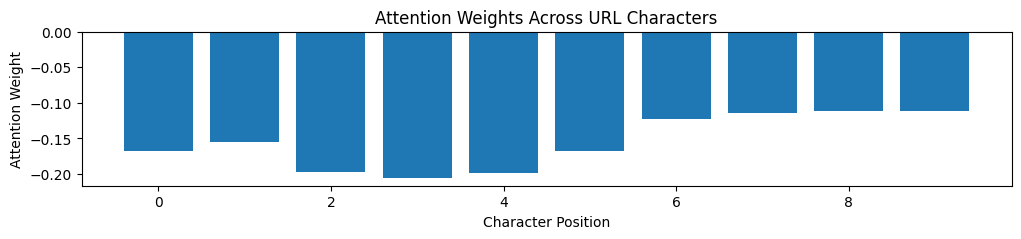


2. INTEGRATED GRADIENTS ANALYSIS (CharCNN+GRU):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
Integrated Gradients Analysis for class: phishing
Prediction confidence: 0.9795

3. LIME EXPLANATIONS (CharCNN+GRU):
LIME Explanation for URL: google.com
Feature-based explanation (simplified LIME):
length: 10
num_dots: 1
num_slashes: 0
num_hyphens: 0
has_@: 0
num_?: 0
num_=: 0
has_http: 0
has_https: 0
has_php: 0

4. ADVERSARIAL EXAMPLES ANALYSIS (CharCNN+GRU):
Generating adversarial example for: google.com
Target class: defacement
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Original prediction: 3 (phishing)
Original confidence: 0.9795

Adversarial modifications tested:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1. google.com/test... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2. google.net... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3. google.com?param=test... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
4. http://google.com... -> 3 (phishing)

---------------------------------

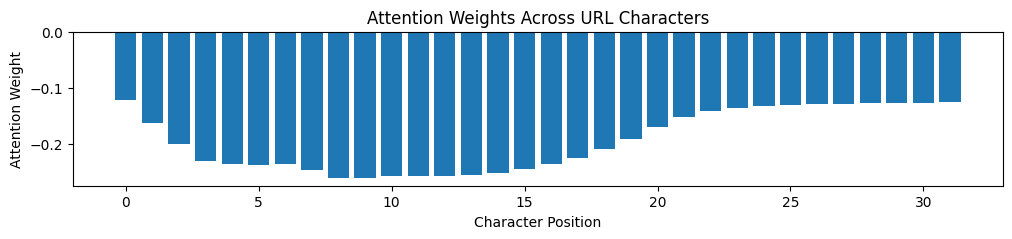


2. INTEGRATED GRADIENTS ANALYSIS (CharCNN+GRU):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Integrated Gradients Analysis for class: phishing
Prediction confidence: 0.9453

3. LIME EXPLANATIONS (CharCNN+GRU):
LIME Explanation for URL: paypal-security-verification.com
Feature-based explanation (simplified LIME):
length: 32
num_dots: 1
num_slashes: 0
num_hyphens: 2
has_@: 0
num_?: 0
num_=: 0
has_http: 0
has_https: 0
has_php: 0

4. ADVERSARIAL EXAMPLES ANALYSIS (CharCNN+GRU):
Generating adversarial example for: paypal-security-verification.com
Target class: defacement
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Original prediction: 3 (phishing)
Original confidence: 0.9453

Adversarial modifications tested:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1. paypal-security-verification.com/test... -> 0 (benign)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
2. paypal-security-verification.net... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
3. paypal-security-verification.com?param=test... -> 3 (phishing)
1/1 ━

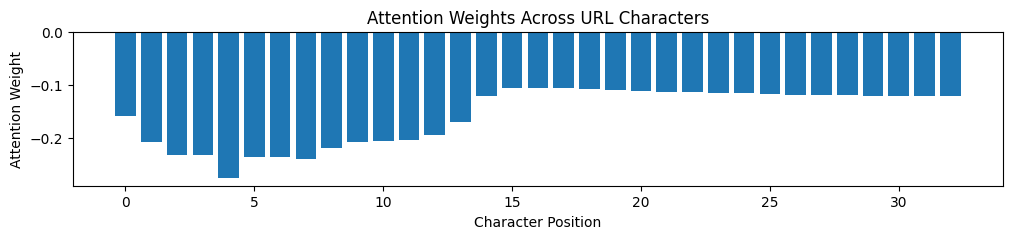


2. INTEGRATED GRADIENTS ANALYSIS (CharCNN+GRU):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Integrated Gradients Analysis for class: phishing
Prediction confidence: 0.9897

3. LIME EXPLANATIONS (CharCNN+GRU):
LIME Explanation for URL: facebook-login.secure-account.com
Feature-based explanation (simplified LIME):
length: 33
num_dots: 2
num_slashes: 0
num_hyphens: 2
has_@: 0
num_?: 0
num_=: 0
has_http: 0
has_https: 0
has_php: 0

4. ADVERSARIAL EXAMPLES ANALYSIS (CharCNN+GRU):
Generating adversarial example for: facebook-login.secure-account.com
Target class: defacement
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Original prediction: 3 (phishing)
Original confidence: 0.9897

Adversarial modifications tested:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1. facebook-login.secure-account.com/test... -> 0 (benign)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
2. facebook-login.secure-account.net... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
3. facebook-login.secure-account.com?param=test... -> 3 (phishing)


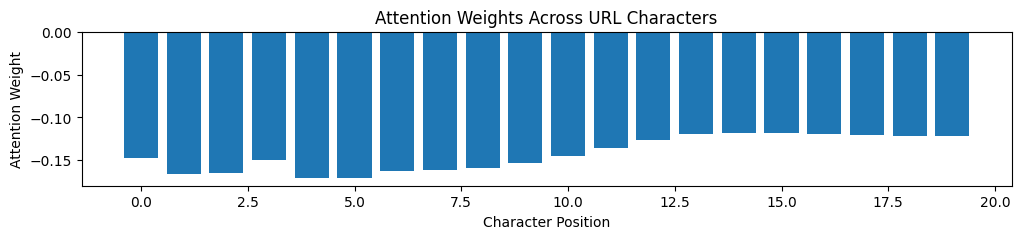


2. INTEGRATED GRADIENTS ANALYSIS (CharCNN+GRU):
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Integrated Gradients Analysis for class: phishing
Prediction confidence: 0.8784

3. LIME EXPLANATIONS (CharCNN+GRU):
LIME Explanation for URL: github.com/api/login
Feature-based explanation (simplified LIME):
length: 20
num_dots: 1
num_slashes: 2
num_hyphens: 0
has_@: 0
num_?: 0
num_=: 0
has_http: 0
has_https: 0
has_php: 0

4. ADVERSARIAL EXAMPLES ANALYSIS (CharCNN+GRU):
Generating adversarial example for: github.com/api/login
Target class: defacement
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
Original prediction: 3 (phishing)
Original confidence: 0.8784

Adversarial modifications tested:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1. github.com/api/login/test... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
2. github.net/api/login... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
3. github.com/api/login?param=test... -> 3 (phishing)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
4. http://github.com/api/

In [18]:
# Interpretability Analysis
print("\n" + "="*60)
print("INTERPRETABILITY ANALYSIS")
print("="*60)

interpretability = ModelInterpretability(models, preprocessor, class_names)

# Test URLs for interpretability analysis
test_urls = [
    "google.com",
    "paypal-security-verification.com",
    "facebook-login.secure-account.com",
    "github.com/api/login"
]

for i, test_url in enumerate(test_urls):
    print(f"\n{'='*40}")
    print(f"INTERPRETABILITY ANALYSIS FOR URL {i+1}: {test_url}")
    print(f"{'='*40}")
    
    # 1. Attention Weights Analysis (CharCNN+GRU)
    print("\n1. ATTENTION WEIGHTS ANALYSIS (CharCNN+GRU):")
    interpretability.analyze_attention_weights('charcnn_gru', test_url)
    
    # 2. Integrated Gradients
    print("\n2. INTEGRATED GRADIENTS ANALYSIS (CharCNN+GRU):")
    ig_results = interpretability.integrated_gradients_analysis('charcnn_gru', test_url)
    
    # 3. LIME Explanations
    print("\n3. LIME EXPLANATIONS (CharCNN+GRU):")
    lime_results = interpretability.lime_explanation('charcnn_gru', test_url)
    
    # 4. Adversarial Examples
    print("\n4. ADVERSARIAL EXAMPLES ANALYSIS (CharCNN+GRU):")
    adversarial_examples = interpretability.adversarial_example_analysis('charcnn_gru', test_url, target_class=1)
    
    print("\n" + "-"*50)

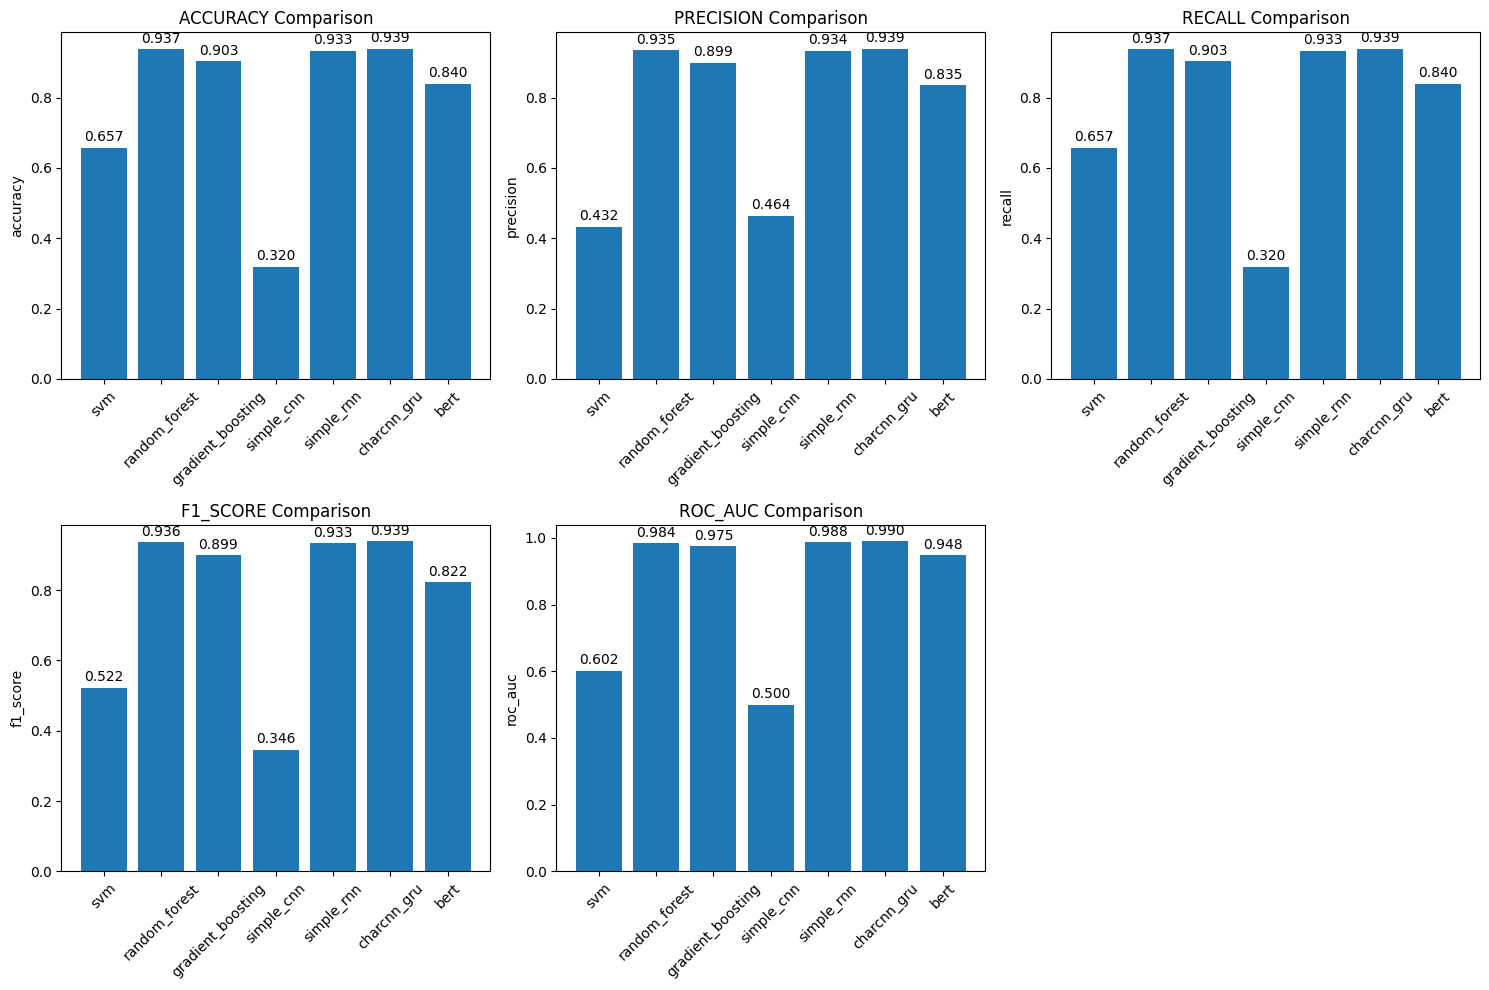

In [19]:
# Model comparison visualization
metrics = ['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']
plt.figure(figsize=(15, 10))
for i, metric in enumerate(metrics):
    plt.subplot(2, 3, i+1)
    values = [all_results[model].get(metric, 0) for model in all_results.keys()]
    plt.bar(all_results.keys(), values)
    plt.title(f'{metric.upper()} Comparison')
    plt.xticks(rotation=45)
    plt.ylabel(metric)
    
    for j, v in enumerate(values):
        plt.text(j, v + 0.01, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


Best model: charcnn_gru
4070/4070 ━━━━━━━━━━━━━━━━━━━━ 13s 3ms/step


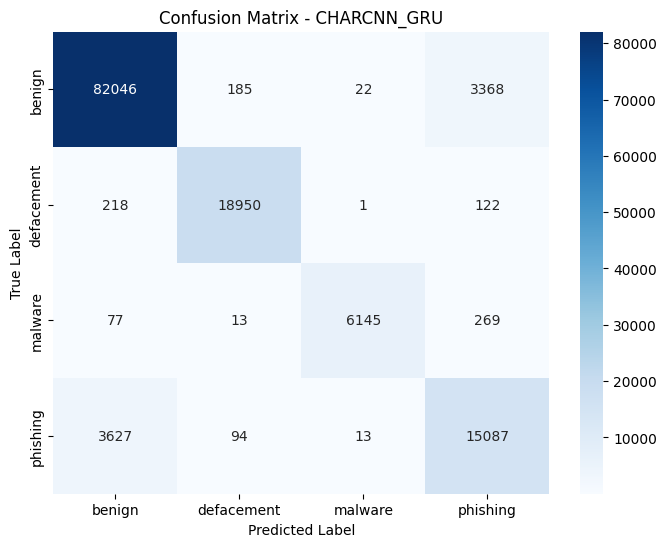

In [20]:
# Confusion matrix for best model
best_model_name = max(all_results.items(), key=lambda x: x[1]['f1_score'])[0]
print(f"\nBest model: {best_model_name}")

if best_model_name in ['svm', 'random_forest', 'gradient_boosting']:
    y_pred_best = models[best_model_name].predict(X_test_ml)
elif best_model_name == 'bert':
    y_pred_best = np.argmax(models[best_model_name].model.predict(
        [X_test_bert['input_ids'], X_test_bert['attention_mask']]), axis=1)
else:
    y_pred_best = np.argmax(models[best_model_name].model.predict(X_test_char), axis=1)

plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred_best)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title(f'Confusion Matrix - {best_model_name.upper()}')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()